Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             balanced_accuracy_score, f1_score, recall_score, 
                             precision_recall_curve)
from sklearn.calibration import calibration_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


Prepare Data

In [3]:
df = pd.read_csv(r"C:\\Users\\lomar\\Documents\\Mariam - Master's\\MRP\\heart_2022_no_nans.csv")

target = 'HadHeartAttack'
X = df.drop(columns=[target])
y = df[target]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


Preprocessing Pipeline

In [4]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Training function

In [5]:
def train_model(model, X_train, y_train, X_test, y_test, name="Model", threshold=0.5):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n===== {name} =====")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    return pipeline, y_proba, y_pred


In [6]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_pipeline, lr_proba, lr_pred = train_model(lr_model, X_train, y_train, X_test, y_test, "Logistic Regression")



===== Logistic Regression =====
Balanced Accuracy: 0.7948
ROC AUC: 0.8821
              precision    recall  f1-score   support

           0     0.9832    0.8382    0.9049     46518
           1     0.2115    0.7514    0.3301      2687

    accuracy                         0.8335     49205
   macro avg     0.5973    0.7948    0.6175     49205
weighted avg     0.9410    0.8335    0.8735     49205



<Figure size 1000x600 with 0 Axes>

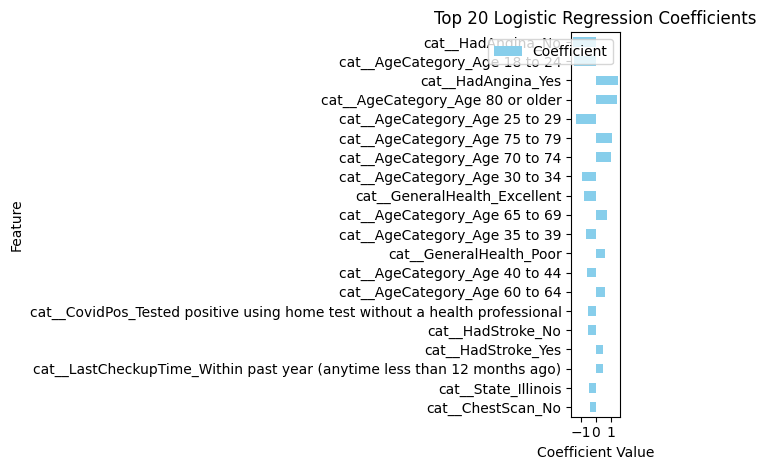

,Feature,Coefficient
77,cat__HadAngina_No,-1.459756
124,cat__AgeCategory_Age 18 to 24,-1.456935
78,cat__HadAngina_Yes,1.434987
136,cat__AgeCategory_Age 80 or older,1.355525
125,cat__AgeCategory_Age 25 to 29,-1.314278
...,...,...
22,cat__State_Iowa,-0.002696
72,cat__PhysicalActivities_Yes,-0.002566
85,cat__HadCOPD_No,0.001686
93,cat__HadDiabetes_No,0.001471


In [7]:
def interpret_logistic_coefficients(pipeline, feature_names):
    lr = pipeline.named_steps['classifier']
    coefs = lr.coef_[0]
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    coef_df.head(20).plot(x='Feature', y='Coefficient', kind='barh', color='skyblue')
    plt.title('Top 20 Logistic Regression Coefficients')
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return coef_df
encoded_features = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()
interpret_logistic_coefficients(lr_pipeline, encoded_features)


In [8]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_pipeline, rf_proba, rf_pred = train_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")


===== Random Forest =====
Balanced Accuracy: 0.6526
ROC AUC: 0.8721
              precision    recall  f1-score   support

           0     0.9617    0.9829    0.9722     46518
           1     0.5217    0.3223    0.3984      2687

    accuracy                         0.9469     49205
   macro avg     0.7417    0.6526    0.6853     49205
weighted avg     0.9377    0.9469    0.9409     49205



In [9]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)

param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__min_child_weight': [1, 3],
    'classifier__gamma': [0, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

xgb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb)
])

search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Lowered from 20
    scoring='f1',
    n_jobs=2,  # Lowered from -1
    pre_dispatch='2*n_jobs',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

xgb_best = search.best_estimator_
xgb_proba = xgb_best.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\lomar\Documents\Mariam - Master's\Fall 2024\DS8003 (Big Data)\finalproject\elk-kafka\.conda\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:30:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Threshold Tuning

In [10]:
thresholds = np.arange(0.3, 0.7, 0.05)
best_thresh = 0.5
best_f1 = 0

for t in thresholds:
    preds = (xgb_proba >= t).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"\nBest XGBoost Threshold: {best_thresh:.2f} with F1: {best_f1:.4f}")

xgb_pred_final = (xgb_proba >= best_thresh).astype(int)
print("\n===== XGBoost (Tuned) =====")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, xgb_pred_final):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, xgb_proba):.4f}")
print(classification_report(y_test, xgb_pred_final, digits=4))



Best XGBoost Threshold: 0.65 with F1: 0.4115

===== XGBoost (Tuned) =====
Balanced Accuracy: 0.7787
ROC AUC: 0.8868
              precision    recall  f1-score   support

           0     0.9780    0.9144    0.9451     46518
           1     0.3025    0.6431    0.4115      2687

    accuracy                         0.8995     49205
   macro avg     0.6402    0.7787    0.6783     49205
weighted avg     0.9411    0.8995    0.9159     49205



Feature Importance

['HadAngina_No' 'HadAngina_Yes' 'ChestScan_Yes' 'ChestScan_No'
 'RemovedTeeth_None of them' 'PneumoVaxEver_Yes' 'PneumoVaxEver_No'
 'HadDiabetes_Yes' 'HadArthritis_No' 'HadStroke_No'
 'AgeCategory_Age 80 or older' 'HadDiabetes_No' 'HadStroke_Yes'
 'HadArthritis_Yes' 'DifficultyWalking_Yes' 'GeneralHealth_Fair'
 'RemovedTeeth_1 to 5' 'GeneralHealth_Very good' 'PhysicalHealthDays'
 'LastCheckupTime_Within past year (anytime less than 12 months ago)']


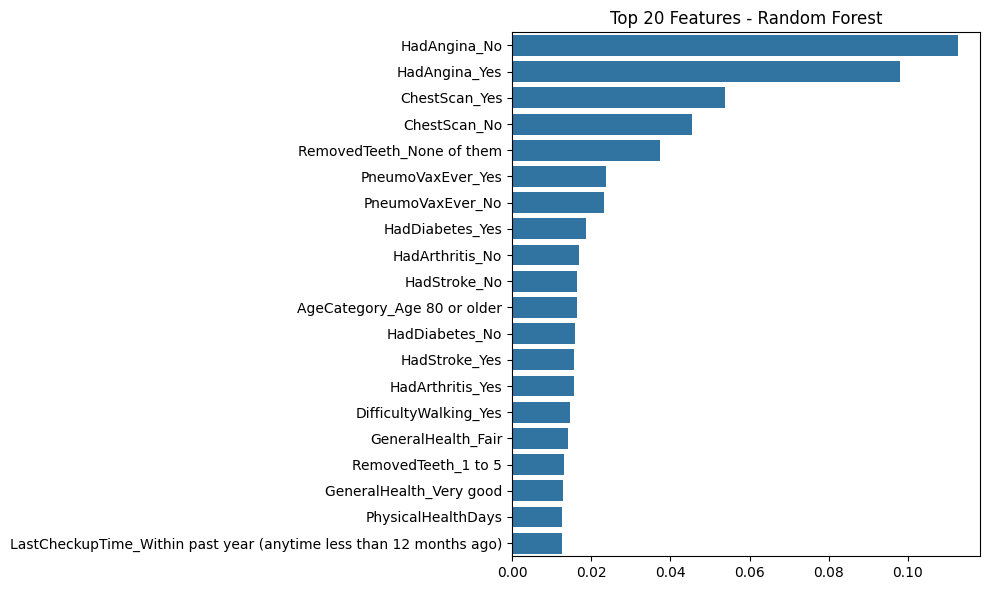

['HadAngina_Yes' 'ChestScan_Yes' 'AlcoholDrinkers_Yes' 'CovidPos_No'
 'PneumoVaxEver_Yes'
 'TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years'
 'HIVTesting_Yes' 'AgeCategory_Age 65 to 69' 'SmokerStatus_Never smoked'
 'RaceEthnicityCategory_White only, Non-Hispanic' 'PhysicalActivities_No'
 'TetanusLast10Tdap_Yes, received tetanus shot but not sure what type'
 'HadArthritis_No' 'FluVaxLast12_No'
 'ECigaretteUsage_Never used e-cigarettes in my entire life'
 'AgeCategory_Age 80 or older' 'AgeCategory_Age 60 to 64'
 'SmokerStatus_Former smoker' 'HadDiabetes_No' 'PneumoVaxEver_No']


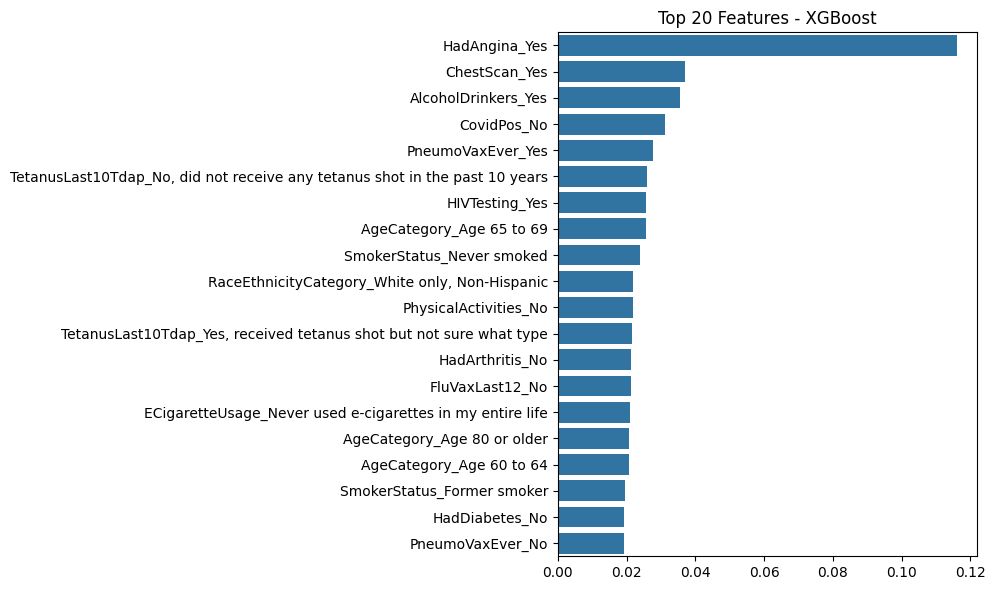

In [11]:
def plot_importance(model, model_name, feature_names, top_n=20):
    importance = model.feature_importances_
    idx = np.argsort(importance)[::-1][:top_n]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance[idx], y=np.array(feature_names)[idx])
    print(np.array(feature_names)[idx])
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.tight_layout()
    plt.show()

preprocessor.fit(X_train)
ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, ohe_cols])

plot_importance(rf_pipeline.named_steps['classifier'], 'Random Forest', feature_names)
plot_importance(xgb_best.named_steps['classifier'], 'XGBoost', feature_names)


Calibaration Curve

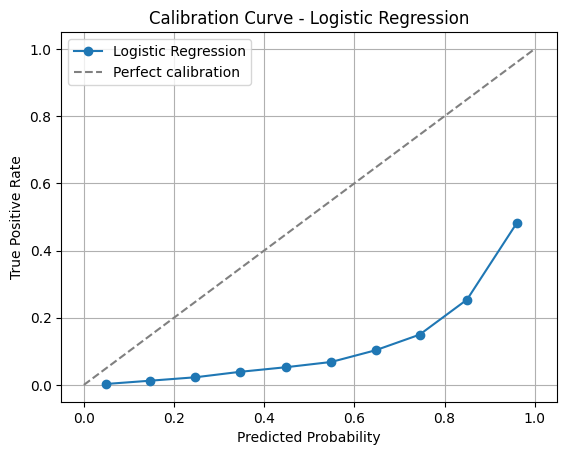

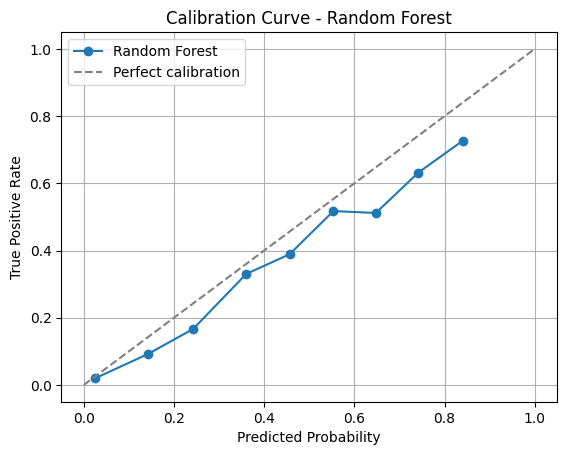

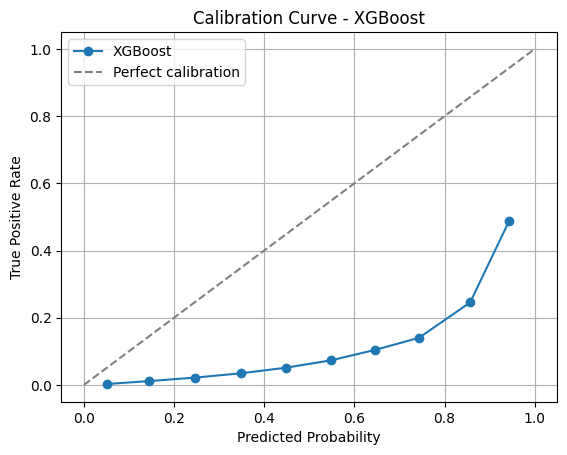

In [12]:
def plot_calibration_curve(model, X, y_true, model_name):
    y_proba = model.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)
    
    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
    plt.title(f'Calibration Curve - {model_name}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_calibration_curve(lr_pipeline, X_test, y_test, "Logistic Regression")
plot_calibration_curve(rf_pipeline, X_test, y_test, "Random Forest")
plot_calibration_curve(xgb_best, X_test, y_test, "XGBoost")



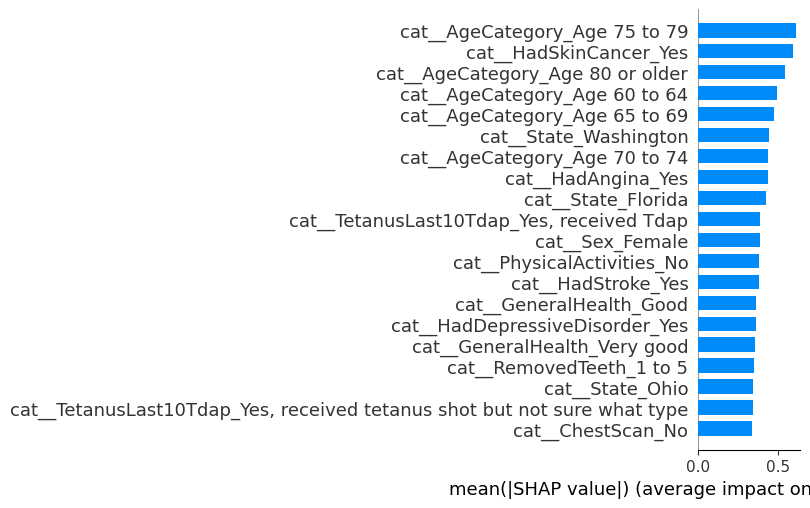

In [ ]:
# import shap

# xgb_model = xgb_best.named_steps['classifier']
# preprocessor = xgb_best.named_steps['preprocessor']
# X_test_transformed = preprocessor.transform(X_test)
# if hasattr(X_test_transformed, "toarray"):
#     X_test_transformed = X_test_transformed.toarray()
# feature_names = preprocessor.get_feature_names_out()
# X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X_test_transformed_df)

# shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", show=False)
# fig = plt.gcf()
# fig.set_size_inches(10, 6)  # wider and taller
# plt.subplots_adjust(bottom=0.25)
# plt.show()



Final CV

In [13]:
cv_scores = cross_val_score(xgb_best, X, y_encoded, scoring='f1', cv=3, n_jobs=2)
print(f"\nCross-validated F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")



Cross-validated F1 scores: [0.314403   0.33365091 0.32890695]
Mean F1: 0.3257, Std: 0.0082


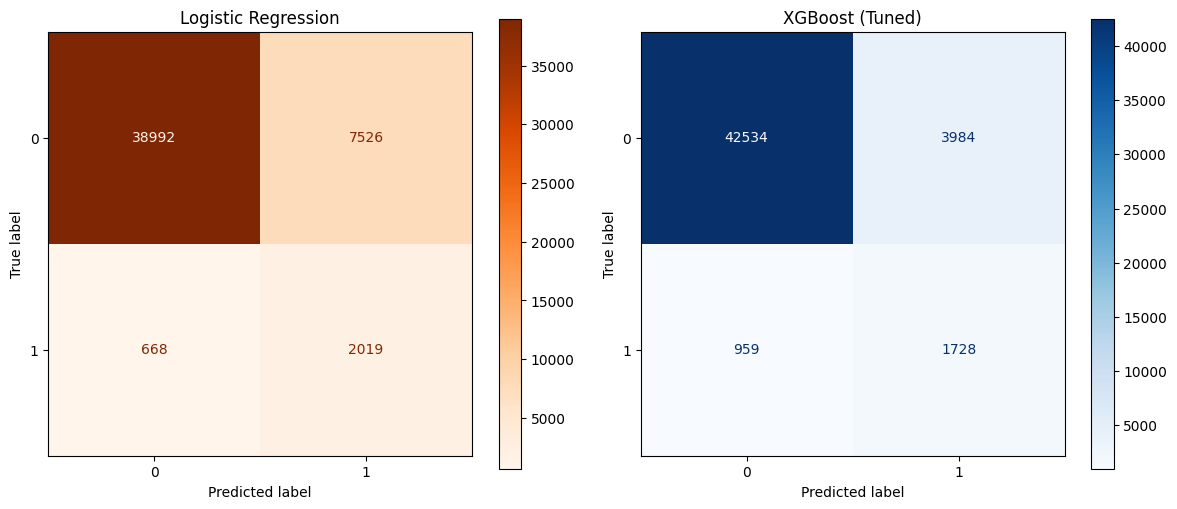

In [14]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test, lr_pred, ax=axes[0], cmap='Oranges', values_format='d'
)
axes[0].set_title('Logistic Regression')

# XGBoost
ConfusionMatrixDisplay.from_predictions(
    y_test, xgb_pred_final, ax=axes[1], cmap='Blues', values_format='d'
)
axes[1].set_title('XGBoost (Tuned)')

plt.tight_layout()
plt.show()
